## TechPoint Xtern WSA (Part 1)

In [2]:
import googlemaps
from googlemaps import places
import pandas as pd
from IPython.display import Image
import numpy as np

gmaps = googlemaps.Client(key=open('apikey.txt', 'r').read())

### Getting the data

I am using Google Maps Platform's Places API

API functions:
- https://github.com/googlemaps/google-maps-services-python/blob/master/googlemaps/places.py
    - "type" parameter: https://developers.google.com/places/supported_types
- https://github.com/googlemaps/google-maps-services-python/blob/master/googlemaps/directions.py
- https://github.com/googlemaps/google-maps-services-python/blob/master/googlemaps/maps.py


Please note that the places.places() and places.place() functions are free. However, other functions in the places module are not.
- Ref: https://developers.google.com/maps/documentation/places/web-service/usage-and-billing?hl=en_US

In [12]:
Image(url="img\\reference_loc_and_radius.png", width=600, height=600)

This is how I determined the radius to use in the places.places() function.

For the 1st point, I eyeballed the centroid of downtown Indianapolism which is denoted by the dotted red border.

I wanted to include the Indianapolis Zoo as the furthest destination, so I selected the 2nd point accordingly.

Then, using Google Maps' "Measure distance" feature, I measured the distance between the two points, which is 1.96 km.

For initial cleaning of the data (below), I removed places with **rating <= 3** and if they have no **website**.

I also removed places with coordinates (**lat**, **long**) outside a box that contains Downtown Indianapolis. This was necessary because the **radius** in the places.places() function is only a soft constraint. I realized this when I found locations that aren't even in Indianapolis.

In [3]:
queries = ['restaurant','asian restaurant','ice cream','gift shop','mall','park','state park','zoo','stadium', 'bar','museum','tourist']

df = pd.DataFrame()

for query in queries:
    df0 = places.places(client=gmaps, query=query, location=(39.771392,-86.161543), radius=1960, type='point_of_interest')['results']
    
    df1 = pd.DataFrame.from_dict(df0)[['name','place_id','formatted_address','rating','user_ratings_total','types']].sort_values(['rating','user_ratings_total'], ascending=[False,False])
    df1.columns = ['name','place_id','address','rating','rating_count','types']
    
    # df1 = df1.loc[df1.rating_count > 0]
    df1 = df1.loc[df1.rating > 3]
    
    df1.types = [  str(a).strip('[').strip(']').replace("'",'')  for a in df1.types   ]
    
    df1['query'] = query

    df = pd.concat([df,df1])

df = df.loc[df.address.str.contains('Indianapolis')]

df.drop_duplicates(subset=['name','address'], keep='first', inplace=True)

hours = pd.DataFrame(columns=['name', 'lat','lng', 'price_level', 'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday', 'website'])

for place in df.itertuples():
    p = places.place(client=gmaps, place_id=place.place_id)['result']

    if 'opening_hours' in p and 'weekday_text' in p['opening_hours']:
        t1 = {a: b for a,b in [a.replace('–','-').split(': ') for a in p['opening_hours']['weekday_text']]}
    else:
        t1 = {a: '' for a in hours.columns}
        
    t1['name'] = p['name']
    t1['price_level'] = p['price_level'] if 'price_level' in p else None
    t1['website'] = p['website'] if 'website' in p else None
    
    t1['lat'] = p['geometry']['location']['lat']
    t1['lng'] = p['geometry']['location']['lng']
    
    hours = pd.concat([hours, pd.DataFrame.from_dict({ a: [t1[a]] for a  in t1 })])

df = df.merge(hours, on='name', how='outer')

df = df.loc[(df.lat > 39.752242) & (df.lat < 39.789246) & (df.lng > -86.199919) & (df.lng < -86.139853)]
df = df.loc[~df.website.isnull()]
del df['place_id']

df.to_csv('ancillary/retrieved.csv',index=False)
df


,name,address,rating,rating_count,types,query,lat,lng,price_level,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,website
0,Subito,"34 N Delaware St, Indianapolis, IN 46204, Unit...",4.9,296,"meal_takeaway, restaurant, food, point_of_inte...",restaurant,39.767998,-86.154631,1,10:00 AM - 3:00 PM,10:00 AM - 3:00 PM,10:00 AM - 3:00 PM,10:00 AM - 3:00 PM,10:00 AM - 3:00 PM,Closed,Closed,http://www.subitosoups.com/
1,Sauce on the Side®,"130 S Pennsylvania St Suite 2, Indianapolis, I...",4.8,235,"meal_delivery, restaurant, food, point_of_inte...",restaurant,39.764600,-86.156714,2,11:00 AM - 9:00 PM,11:00 AM - 9:00 PM,11:00 AM - 9:00 PM,11:00 AM - 9:00 PM,11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,12:00 - 8:00 PM,http://www.sauceontheside.com/
2,Harry & Izzy's,"153 S Illinois St, Indianapolis, IN 46225, Uni...",4.7,2962,"restaurant, food, point_of_interest, establish...",restaurant,39.764575,-86.159660,4,11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,11:00 AM - 11:00 PM,11:00 AM - 11:00 PM,12:00 - 9:00 PM,http://www.harryandizzys.com/
3,Yats,"AVENUE, 910 W 10th St, Indianapolis, IN 46202,...",4.7,502,"restaurant, food, point_of_interest, establish...",restaurant,39.781107,-86.175015,1,11:00 AM - 8:00 PM,11:00 AM - 8:00 PM,11:00 AM - 8:00 PM,11:00 AM - 8:00 PM,11:00 AM - 8:00 PM,Closed,Closed,https://yatscajuncreole.com/wp/indiana/
4,Bru Burger Bar,"410 Massachusetts Ave, Indianapolis, IN 46204,...",4.5,4536,"bar, restaurant, food, point_of_interest, esta...",restaurant,39.773332,-86.152135,2,11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,11:00 AM - 11:00 PM,11:00 AM - 11:00 PM,11:00 AM - 10:00 PM,https://www.bruburgerbar.com/Locations/Bru-Indy/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,Soldiers & Sailors Monument,"1 Monument Cir, Indianapolis, IN 46204, United...",4.7,8028,"tourist_attraction, point_of_interest, establi...",tourist,39.768546,-86.158044,None,Closed,Closed,Closed,Closed,10:30 AM - 5:30 PM,10:30 AM - 5:30 PM,10:30 AM - 5:30 PM,http://www.in.gov/iwm
187,Indianapolis Canal Walk,"Canal Walk, Indianapolis, IN 46202, United States",4.7,2288,"park, tourist_attraction, point_of_interest, e...",tourist,39.775204,-86.165168,None,7:00 AM - 8:00 PM,7:00 AM - 8:00 PM,7:00 AM - 8:00 PM,7:00 AM - 8:00 PM,7:00 AM - 8:00 PM,7:00 AM - 8:00 PM,7:00 AM - 8:00 PM,https://www.whiteriverstatepark.org/
188,Indiana Historical Society,"450 W Ohio St, Indianapolis, IN 46202, United ...",4.7,842,"tourist_attraction, museum, point_of_interest,...",tourist,39.770235,-86.165541,None,Closed,10:00 AM - 5:00 PM,10:00 AM - 5:00 PM,10:00 AM - 5:00 PM,10:00 AM - 5:00 PM,10:00 AM - 5:00 PM,Closed,http://www.indianahistory.org/
189,Indiana Statehouse,"200 W Washington St, Indianapolis, IN 46204, U...",4.6,224,"tourist_attraction, local_government_office, p...",tourist,39.768748,-86.162642,None,8:00 AM - 5:00 PM,8:00 AM - 5:00 PM,8:00 AM - 5:00 PM,8:00 AM - 5:00 PM,8:00 AM - 5:00 PM,10:00 AM - 2:00 PM,Closed,https://www.in.gov/idoa/2371.htm


### Ratings - exploratory statistics

To visualize the data, I made boxplots for **rating** by **query**, **rating_count** by **query**, and **rating_count** by **rating**.

Since we still want to have a diverse itinerary, it is less useful to compare ratings between the queries.

Thus, I only analyzed the with **rating_count** by **rating** plots.

In [4]:

query_rating_stats = df.groupby('query').agg({'name': ['count'], 'rating': ['min', lambda x: x.quantile(0.25), 'median', lambda x: x.quantile(0.75), 'max', 'mean'], \
    'rating_count': ['min', lambda x: x.quantile(0.25), 'median', lambda x: x.quantile(0.75), 'max', 'mean']}).reset_index()
query_rating_stats

query  name rating                                              \
                     count    min <lambda_0> median <lambda_1>  max      mean   
0   asian restaurant    18    3.8      4.125   4.30      4.475  4.9  4.294444   
1                bar    14    4.0      4.125   4.30      4.500  4.6  4.321429   
2          gift shop    10    3.8      4.525   4.70      4.775  5.0  4.590000   
3          ice cream    16    3.5      4.175   4.60      4.825  5.0  4.506250   
4               mall     2    4.1      4.275   4.45      4.625  4.8  4.450000   
5             museum    12    3.6      4.500   4.65      4.725  4.8  4.558333   
6               park    11    4.0      4.300   4.50      4.700  5.0  4.509091   
7         restaurant    18    4.2      4.400   4.50      4.500  4.9  4.500000   
8            stadium     6    3.6      4.450   4.65      4.775  5.0  4.516667   
9         state park     6    4.5      4.525   4.65      4.775  5.0  4.683333   
10           tourist     7    3.8      4.650   4.70      4.750  4.8  4.585714   
11               zoo     5    4.3      4.500   4.80      4.800  5.0  4.680000   

   rating_count                                                    
            min <lambda_0>  median <lambda_1>    max         mean  
0            13     223.50   412.0     576.50   1824   532.333333  
1            37     277.25   586.5     993.75   3292   818.071429  
2             5       9.75    30.5      64.00    414    83.400000  
3             1      39.75   106.0     247.00   1182   207.250000  
4            59    2560.75  5062.5    7564.25  10066  5062.500000  
5             8      37.75   115.5     727.75   3335   705.250000  
6             6      19.00    43.0      68.50    191    56.272727  
7            18     339.50   992.0    2293.25   4536  1358.166667  
8             1     168.25  2402.5    8326.00  12357  4481.166667  
9             2       8.75    47.5    1209.75   4460  1025.000000  
10           40     151.50   842.0    2075.50   8028  1909.142857  
11            2       6.00    54.0     171.00  16728  3392.200000

<AxesSubplot: title={'center': 'rating'}, xlabel='query'>

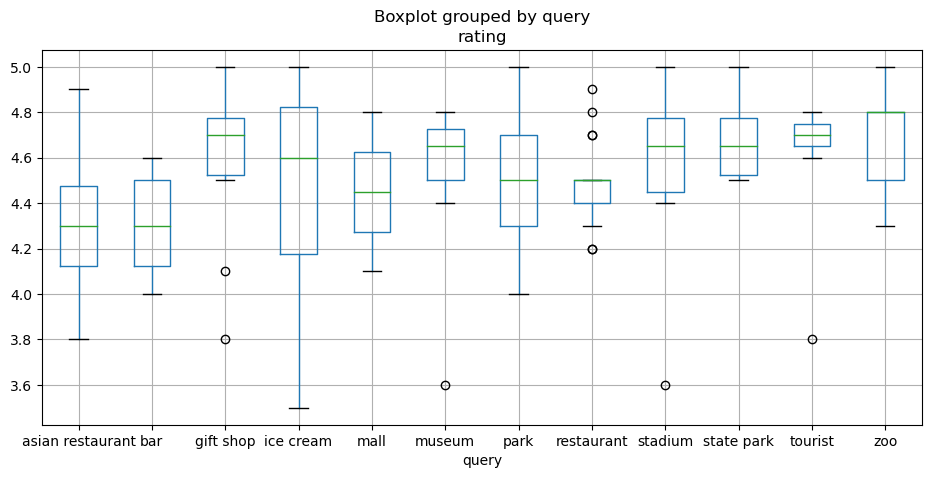

In [5]:
df.boxplot(column='rating', by='query', figsize=(11,5))

<AxesSubplot: title={'center': 'rating_count'}, xlabel='query'>

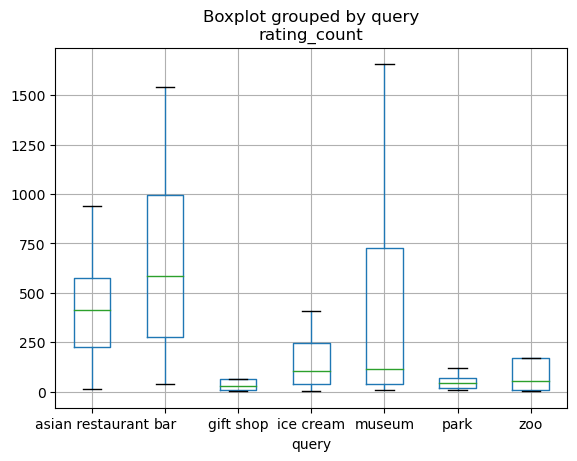

In [6]:
df_temp = df.loc[~df['query'].isin(['mall','restaurant', 'stadium', 'tourist', 'state park']),:]
df_temp.boxplot(column='rating_count', by='query', showfliers=False)

<AxesSubplot: title={'center': 'rating_count'}, xlabel='query'>

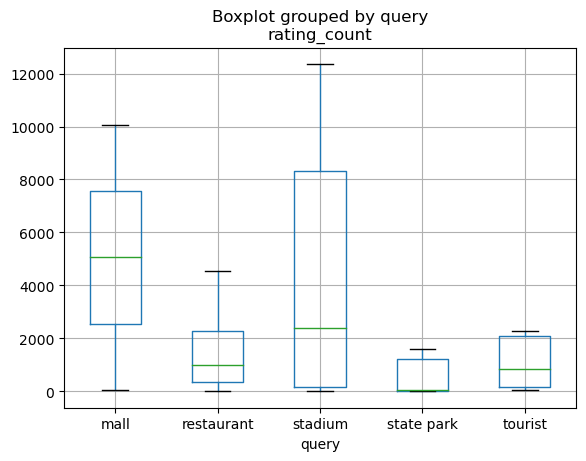

In [7]:
df_temp = df.loc[df['query'].isin(['mall','restaurant', 'stadium', 'tourist', 'state park']),:]
df_temp.boxplot(column='rating_count', by='query', showfliers=False)

In [8]:
stats_per_rating = df.groupby('rating').agg({'name': ['count'], 'rating_count': ['min', lambda x: x.quantile(0.25), 'median', lambda x: x.quantile(0.75), 'max', 'mean']}).reset_index()
stats_per_rating

rating  name rating_count                                                 
          count          min <lambda_0> median <lambda_1>    max         mean
0     3.5     1           95      95.00   95.0      95.00     95    95.000000
1     3.6     2           22      49.25   76.5     103.75    131    76.500000
2     3.8     4            5      60.50  178.0     422.75    860   305.250000
3     3.9     2           70     508.50  947.0    1385.50   1824   947.000000
4     4.0     4           45     286.50  427.5     581.25    861   440.250000
5     4.1     7           30     190.50  396.0     914.50  10066  1814.571429
6     4.2    10           37      56.00  179.0     566.50   2510   573.000000
7     4.3     6           18     154.75  512.0     920.25   3292   904.333333
8     4.4    11           33     156.00  418.0    1061.50   2766   736.181818
9     4.5    20            2      64.75  615.5    1500.00  16728  1681.200000
10    4.6    14           31     206.75  288.0    1275.50   9593  1304.500000
11    4.7    16            6      59.50  458.0    2519.50  12357  2170.875000
12    4.8    16            6      42.25  129.5     207.50   4525   494.437500
13    4.9     3            7     115.00  223.0     259.50    296   175.333333
14    5.0     9            1       2.00    5.0      12.00     21     7.000000

<AxesSubplot: title={'center': 'rating_count'}, xlabel='rating'>

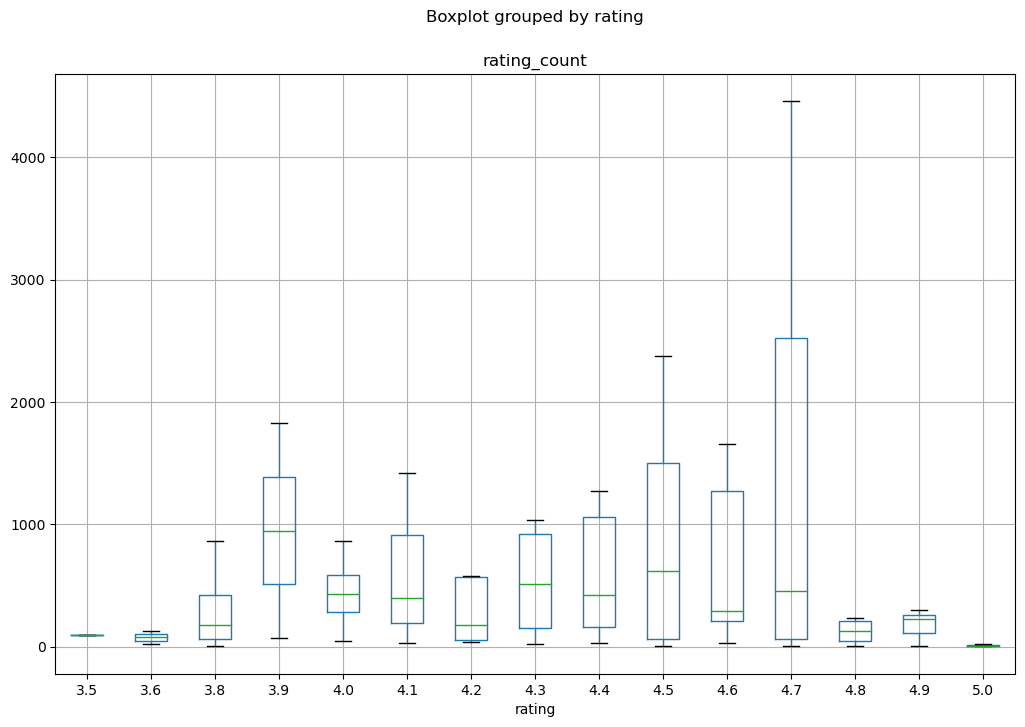

In [9]:
df.boxplot(column='rating_count', by='rating', showfliers=False, figsize=(12,8))

The figure above contains a boxplot of **rating_count** for each **rating** (in 0.1 increments). Outliers are removed. The exact values are shown in the **stats_per_rating** dataframe.

Though we want to visit high-rated places, we must consider the sample size, which is **rating_count** (the number of reviewers). A place with more reviewers would boost our confidence that its rating is reliable.

We can see that places with the max **rating=5.0** have a very low number of reviews. Meanwhile, places with **rating=4.9** have significantly more.

As we decrease **rating** threshold, the number of ratings increases dramatically until **rating=4.7**.

Since we can only visit a handful of places within a day, it is highly likely that we can find a good itinerary among the places that have **rating=4.9** and a sufficient sample size (**rating_count**).

If not, we can always decrease the **rating** threshold until we do.

### Candidate places

I chose a sample size (**rating_count**) threshold of 100. This is approximately between the 50th and 75th percentiles for **rating=4.9**, and more than the 25th percentile for **rating=4.8**.

For each **rating >= 4.3** , I find retrieve the destinations with above the 25th percentile **rating_count** for that **rating**.

I exported the file with an extra **select** column for me to fill out and use for the next part.

In [10]:


cand = df.loc[((df.rating_count >= df.loc[df.rating == 4.9, 'rating_count'].quantile(0.25)) & (df.rating >= 4.9)) | 
              ((df.rating_count >= df.loc[df.rating == 4.8, 'rating_count'].quantile(0.25)) & (df.rating == 4.8)) | 
              ((df.rating_count >= df.loc[df.rating == 4.7, 'rating_count'].quantile(0.25)) & (df.rating == 4.7)) | 
              ((df.rating_count >= df.loc[df.rating == 4.6, 'rating_count'].quantile(0.25)) & (df.rating == 4.6)) | 
              ((df.rating_count >= df.loc[df.rating == 4.5, 'rating_count'].quantile(0.25)) & (df.rating == 4.5)) | 
              ((df.rating_count >= df.loc[df.rating == 4.4, 'rating_count'].quantile(0.25)) & (df.rating == 4.4)) |
              ((df.rating_count >= df.loc[df.rating == 4.3, 'rating_count'].quantile(0.25)) & (df.rating == 4.3))
            ]
cand.insert(0,'select',None)
del cand['types']
df.rename(columns={'query':'type'}, inplace=True)
cand.to_csv('ancillary/cand.csv',index=False)
cand

,select,name,address,rating,rating_count,query,lat,lng,price_level,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,website
0,None,Subito,"34 N Delaware St, Indianapolis, IN 46204, Unit...",4.9,296,restaurant,39.767998,-86.154631,1,10:00 AM - 3:00 PM,10:00 AM - 3:00 PM,10:00 AM - 3:00 PM,10:00 AM - 3:00 PM,10:00 AM - 3:00 PM,Closed,Closed,http://www.subitosoups.com/
1,None,Sauce on the Side®,"130 S Pennsylvania St Suite 2, Indianapolis, I...",4.8,235,restaurant,39.764600,-86.156714,2,11:00 AM - 9:00 PM,11:00 AM - 9:00 PM,11:00 AM - 9:00 PM,11:00 AM - 9:00 PM,11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,12:00 - 8:00 PM,http://www.sauceontheside.com/
2,None,Harry & Izzy's,"153 S Illinois St, Indianapolis, IN 46225, Uni...",4.7,2962,restaurant,39.764575,-86.159660,4,11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,11:00 AM - 11:00 PM,11:00 AM - 11:00 PM,12:00 - 9:00 PM,http://www.harryandizzys.com/
3,None,Yats,"AVENUE, 910 W 10th St, Indianapolis, IN 46202,...",4.7,502,restaurant,39.781107,-86.175015,1,11:00 AM - 8:00 PM,11:00 AM - 8:00 PM,11:00 AM - 8:00 PM,11:00 AM - 8:00 PM,11:00 AM - 8:00 PM,Closed,Closed,https://yatscajuncreole.com/wp/indiana/
4,None,Bru Burger Bar,"410 Massachusetts Ave, Indianapolis, IN 46204,...",4.5,4536,restaurant,39.773332,-86.152135,2,11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,11:00 AM - 11:00 PM,11:00 AM - 11:00 PM,11:00 AM - 10:00 PM,https://www.bruburgerbar.com/Locations/Bru-Indy/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,None,The Escape Room Indianapolis,"200 S Meridian St STE 220, Indianapolis, IN 46...",4.8,1863,tourist,39.763947,-86.158445,None,1:00 - 10:00 PM,10:30 AM - 10:00 PM,10:30 AM - 10:00 PM,10:30 AM - 10:00 PM,10:30 AM - 1:30 AM,8:30 AM - 1:30 AM,1:00 - 10:00 PM,https://escaperoomindy.com/
186,None,Soldiers & Sailors Monument,"1 Monument Cir, Indianapolis, IN 46204, United...",4.7,8028,tourist,39.768546,-86.158044,None,Closed,Closed,Closed,Closed,10:30 AM - 5:30 PM,10:30 AM - 5:30 PM,10:30 AM - 5:30 PM,http://www.in.gov/iwm
187,None,Indianapolis Canal Walk,"Canal Walk, Indianapolis, IN 46202, United States",4.7,2288,tourist,39.775204,-86.165168,None,7:00 AM - 8:00 PM,7:00 AM - 8:00 PM,7:00 AM - 8:00 PM,7:00 AM - 8:00 PM,7:00 AM - 8:00 PM,7:00 AM - 8:00 PM,7:00 AM - 8:00 PM,https://www.whiteriverstatepark.org/
188,None,Indiana Historical Society,"450 W Ohio St, Indianapolis, IN 46202, United ...",4.7,842,tourist,39.770235,-86.165541,None,Closed,10:00 AM - 5:00 PM,10:00 AM - 5:00 PM,10:00 AM - 5:00 PM,10:00 AM - 5:00 PM,10:00 AM - 5:00 PM,Closed,http://www.indianahistory.org/


In [11]:
data = cand.copy()
del data['lat'],data['lng'],data['select'],data['price_level']
data.to_csv('data.csv', index=False)